#Dataset

In [1]:
from dataset import *

In [2]:

import os
import pickle
import numpy as np
import torch

In [3]:
class dataset(Dataset):
    """Adaptive dataset."""

    def __init__(self,db_path='',ids_path='',part='',
                 
                 labels_path=''
                 ):
        self.db_path=db_path       
        self.labels_path=labels_path
        self.ids_path=ids_path
        self.part=part
        
        pickle_in = open(self.ids_path,'rb')
        self.list_IDs= pickle.load(pickle_in)
        self.list_IDs=list(self.list_IDs)
        pickle_in.close()
        
        pickle_in = open(self.labels_path,'rb')
        self.labels = pickle.load(pickle_in)
        pickle_in.close()
        
        
    def __len__(self):
        return int(len(self.list_IDs))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        id=self.list_IDs[idx]
        if id[0] == 'L':
            id='l'+id[1:]
        if id[0] == 'K':
            id='k'+id[1:]

        x=np.load(os.path.join(self.db_path,id+'.npy'))
        x=torch.from_numpy(x)
        x = (x.permute(2,0,1)).float()
        print(x.shape)


        label = self.labels[self.list_IDs[idx]]
        if id.split("/")[0] != 'train':
          label = label * 20
        label = np.array([label])
        label = label.astype('float32')
       
        return x,label

In [4]:
class dataset(Dataset):
    """Adaptive dataset."""

    def __init__(self,db_path='',ids_path='',part='',
                 
                 labels_path=''
                 ):
        self.db_path=db_path       
        self.labels_path=labels_path
        self.ids_path=ids_path
        self.part=part
        
        pickle_in = open(self.ids_path,'rb')
        self.list_IDs= pickle.load(pickle_in)
        self.list_IDs=list(self.list_IDs)
        pickle_in.close()
        
        pickle_in = open(self.labels_path,'rb')
        self.labels = pickle.load(pickle_in)
        pickle_in.close()
        
        ids = []
        for id in self.list_IDs:
            if id.split("/")[0] != 'train':
                continue
            ids.append(id)
        self.list_IDs = ids
        
    def __len__(self):
        return int(len(self.list_IDs))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        id=self.list_IDs[idx]
        if id[0] == 'L':
            id='l'+id[1:]
            
        if id[0] == 'K':
            id='k'+id[1:]

        x=np.load(os.path.join(self.db_path,id+'.npy'))
        x=torch.from_numpy(x)
      # print(x.shape)
        x = (x.permute(2,0,1)).float()
       #x = torch.unsqueeze(x,0)
        label = self.labels[self.list_IDs[idx]]
       # if id.split("/")[0] != 'train':
       #     label = label * 20
        label = np.array([label])
        label = label.astype('float32')
       
        return x,label

**TO EDIT**

In [5]:
train_data=dataset(db_path='./Features/resnet50/',
                        ids_path='ids.pickle',
                        labels_path='./scores1.pickle'
                 )
                 
print(f"Length of Train Data : {len(train_data)}")

val_data=dataset_withIDs(db_path='./Features/resnet50/',
                        ids_path='ids.pickle',
                        labels_path='./scores1.pickle'
                 )
                 
print(f"Length of Train Data : {len(val_data)}")


Length of Train Data : 839


NameError: name 'dataset_withIDs' is not defined

#DataLoader

In [6]:
from torch.utils.data import  DataLoader

In [7]:
batch_size = 1
train_dl = DataLoader(train_data, batch_size, shuffle = True, pin_memory = True)
val_dl = DataLoader(val_data, 1, shuffle = False)

NameError: name 'val_data' is not defined

#Model

In [8]:
from timesformer.models.vit import TimeSformer
import torch.nn as nn

In [9]:
model = TimeSformer(img_size=50,num_classes=1,patch_size=1,num_frames=20,attention_type='divided_space_time')

Pretrained model URL is invalid, using random initialization.


In [9]:
model

TimeSformer(
  (model): VisionTransformer(
    (dropout): Dropout(p=0.0, inplace=False)
    (patch_embed): PatchEmbed(
      (proj): Conv1d(2048, 768, kernel_size=(1,), stride=(1,))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (time_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
        )
        (temporal_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (temporal_attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        

#Train function

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau 
import time
import copy
from tqdm import tqdm

In [10]:
def train_model(model, dataloaders,criterion, optimizer,norm=100,debut=0, num_epochs=25, is_inception=False,scheduler=None):
    since = time.time()

    val_loss_history = []
    loss_history = []
    best_loss=99999999
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(debut,num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for batch_idx, (inputs, labels) in tqdm(enumerate(dataloaders[phase])):
                inputs = inputs.to(device, non_blocking=True)
                labels = (labels.to(device))/norm

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        action_loss=loss
                    preds = outputs

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        action_loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            loss_history.append(epoch_loss)

            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(dataloaders[phase]),
                100. * batch_idx / len(dataloaders[phase]), loss.item()))



            print('{} Loss: {:.4f} '.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            
        scheduler.step(loss_history[-1])
        torch.save(model.state_dict(), 'checkpoint.pth')
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    vloss_history={}
    vloss_history['val']=val_loss_history
    vloss_history['loss']=loss_history
   
    return model, vloss_history

In [11]:
device = torch.device("cuda")
if torch.cuda.is_available():
    model.cuda()

In [11]:
model.cpu()

TimeSformer(
  (model): VisionTransformer(
    (dropout): Dropout(p=0.0, inplace=False)
    (patch_embed): PatchEmbed(
      (proj): Conv1d(2048, 768, kernel_size=(1,), stride=(1,))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (time_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
        )
        (temporal_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (temporal_attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        

#Train

In [26]:
num_epochs =  30
lr = 0.000001

In [27]:
model=model.float()
params_to_update=[]
for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            nn.init.normal_(param, mean=0.0, std=0.5)
opt_func = torch.optim.Adam(params_to_update,lr=lr)
scheduler = ReduceLROnPlateau(opt_func, 'min' ,patience=5,verbose=True)
criterion = nn.MSELoss()

In [12]:
device = torch.device('cpu')

In [13]:
model = model.cpu()

In [37]:
model.load_state_dict(torch.load('checkpoint2.pth',map_location=device))

<All keys matched successfully>

In [29]:
[model,history] = train_model(model,dataloaders={'train':train_dl},optimizer=opt_func,num_epochs=num_epochs,
                    criterion=criterion,scheduler=scheduler,norm=100)

Epoch 0/29
----------


0it [00:00, ?it/s]

torch.Size([2048, 8, 24])


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.75 GiB total capacity; 3.33 GiB already allocated; 17.00 MiB free; 3.65 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [27]:
ls Features/resnet50/

konvid.html  live.html  train/  youtube.html


In [23]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [ ]:
ls

 checkpoint.pth                   ids.pickle               timesformer/
'CNN+TimeSformer (copie).ipynb'   __init__.py              tools.py
 CNN+TimeSformer.ipynb            __MACOSX/                train/
 data.ipynb                       __pycache__/             train_ids.pickle
 dataset.py                       scores1.pickle           train.txt
 Features/                        scores_combined.pickle   validation/
 features_extraction.ipynb        scores.pickle


In [36]:
import matplotlib.pyplot as plt

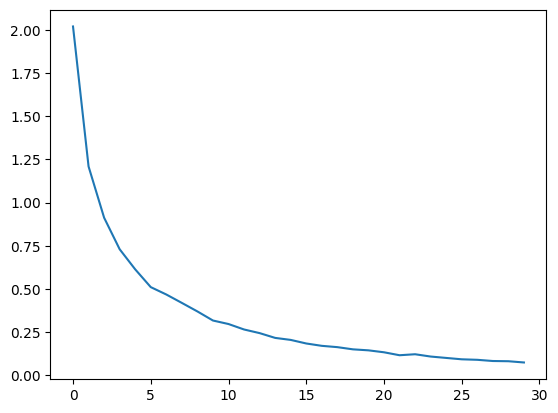

In [55]:
#plt.plot(range(len(history["val"])),history["val"])
plt.plot(range(len(history["loss"])),history["loss"])

#Test

In [21]:
def step(inputs):
    data, label = inputs
    data=data.cpu()
    preds = model(data)
    return preds, label

In [40]:
y_pred*100

[tensor([0.2451]),
 tensor([0.1448]),
 tensor([0.0917]),
 tensor([0.2222]),
 tensor([0.2305]),
 tensor([0.2109]),
 tensor([0.2140]),
 tensor([0.1596]),
 tensor([0.1953]),
 tensor([0.2343]),
 tensor([0.1065]),
 tensor([0.1246]),
 tensor([0.1892]),
 tensor([0.4091]),
 tensor([0.0026]),
 tensor([0.2116]),
 tensor([0.2157]),
 tensor([0.1410]),
 tensor([0.3507]),
 tensor([0.2074]),
 tensor([0.2502]),
 tensor([0.1876]),
 tensor([0.1423]),
 tensor([0.1908]),
 tensor([0.2854]),
 tensor([0.2317]),
 tensor([0.3812]),
 tensor([0.0831]),
 tensor([0.3462]),
 tensor([0.1765]),
 tensor([0.1388]),
 tensor([0.2153]),
 tensor([0.2004]),
 tensor([0.0653]),
 tensor([0.2272]),
 tensor([0.3639]),
 tensor([0.2161]),
 tensor([0.3916]),
 tensor([0.1990]),
 tensor([0.1929]),
 tensor([0.0366]),
 tensor([0.3829]),
 tensor([0.2358]),
 tensor([0.0363]),
 tensor([0.1828]),
 tensor([0.4003]),
 tensor([0.1381]),
 tensor([0.1682]),
 tensor([0.3658]),
 tensor([0.1962]),
 tensor([0.2248]),
 tensor([0.2479]),
 tensor([0.2

In [22]:
val_dl = train_dl

In [38]:
with torch.no_grad():
    y_pred=[]
    label=[]
    for i, batch in enumerate(tqdm(val_dl)):
      
     #  if id[0].split('/')[0] == 'train':
          pred,l = step(batch)
          y_pred.append(pred[0].cpu())
          label.append(float(l[0][0]))


100%|█████████████████████████████████████████| 839/839 [01:45<00:00,  7.94it/s]


In [25]:
import pandas
import scipy.io
import numpy as np
import argparse
import time
import math
import os
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
from concurrent import futures
import functools
import warnings
warnings.filterwarnings("ignore")

def logistic_func(X, bayta1, bayta2, bayta3, bayta4):
  # 4-parameter logistic function
  logisticPart = 1 + np.exp(np.negative(np.divide(X - bayta3, np.abs(bayta4))))
  yhat = bayta2 + np.divide(bayta1 - bayta2, logisticPart)
  return yhat

def compute_metrics(y_pred, y):
  '''
  compute metrics btw predictions & labels
  '''
  # compute SRCC & KRCC
  SRCC = scipy.stats.spearmanr(y, y_pred)[0]
  try:
    KRCC = scipy.stats.kendalltau(y, y_pred)[0]
  except:
    KRCC = scipy.stats.kendalltau(y, y_pred, method='asymptotic')[0]

  # logistic regression btw y_pred & y
  beta_init = [np.max(y), np.min(y), np.mean(y_pred), 0.5]
  popt, _ = curve_fit(logistic_func, y_pred, y, p0=beta_init, maxfev=int(1e8))
  y_pred_logistic = logistic_func(y_pred, *popt)
  
  # compute  PLCC RMSE
  PLCC = scipy.stats.pearsonr(y, y_pred_logistic)[0]
  RMSE = np.sqrt(mean_squared_error(y, y_pred_logistic))
  return [SRCC, KRCC, PLCC, RMSE]

#Scores

In [41]:
y_pred[4]

tensor([0.2305])

In [42]:
y_true[4]

67.82231140136719

In [43]:
y=[]
for i in range(len(y_pred)):
  y.append(y_pred[i].cpu()[0]*100)

In [44]:
y_true=label

In [45]:
[SRCC, KRCC, PLCC, RMSE]=compute_metrics(y,y_true)

In [46]:
SRCC

0.032282964758835284

In [47]:
PLCC

0.06790882407019916

In [48]:
KRCC

0.02148540284063594

In [49]:
RMSE

12.906629867092361

In [ ]:
def load_my_state_dict(model, state_dict,exceptions):
 
        own_state = model.state_dict()
        for name, param in state_dict.items():
          try:
            param = param.data
            own_state[name].copy_(param)
          except:
            print('layer not copied: '+name)
            

In [ ]:
ls *.pth

combined_resnet50.pth


In [ ]:
s=torch.load("./combined_resnet50.pth",map_location=device)

In [ ]:
load_my_state_dict(model,s,'')